In [26]:
import torch
import torch.nn as nn

# My code starts here

In [41]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock,self).__init__()
        #convolution layer
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, stride=stride),
                     nn.Conv2d(out_channels, out_channels, kernel_size, padding=1))
        #batch norm layer
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        #transit the input x's shape to match the output f_x's shape
        self.trans = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
        #if input shape = output shape, no need to transut
        self.isChanged = not in_channels == out_channels
        
    def forward(self, x):
        f_x = self.conv[0](x)
        f_x = self.bn(f_x)
        f_x = self.relu(f_x)
        f_x = self.conv[1](f_x)
        f_x = self.bn(f_x)
        
        #residual path
        if(self.isChanged):
            x = self.trans(x)
        #residual add
        x = f_x + x
        
        x = self.relu(x)
        
        return x
            

In [49]:
class ResNet(nn.Module):
    def __init__(self, output_classes, numBlocks):
        super(ResNet,self).__init__()
        
        self.sumOfRBlocks = sum(numBlocks)
        
        #convolution layer
        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2)
        self.bn = nn.BatchNorm2d(64)
        
        #residual blocks
        self.rblocks = nn.ModuleList()
        for i in range(numBlocks[0]):
            self.rblocks.append(ResidualBlock(64,64))
        
        self.rblocks.append(ResidualBlock(64,128,stride=2))  
        for i in range(numBlocks[1] - 1):   
            self.rblocks.append(ResidualBlock(128,128))
        
        self.rblocks.append(ResidualBlock(128,256,stride=2))
        for i in range(numBlocks[2] - 1):
            self.rblocks.append(ResidualBlock(256,256))
        
        self.rblocks.append(ResidualBlock(256,512,stride=2))
        for i in range(numBlocks[3] - 1):
            self.rblocks.append(ResidualBlock(512,512))

        self.rblocks = nn.Sequential(*self.rblocks)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512, output_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.maxpool(x)
        
        for i in range(self.sumOfRBlocks):
          x = self.rblocks[i](x)
        
        x = self.avgpool(x)
        #reshape
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

In [50]:
from torchsummary import summary

In [51]:
resnet = ResNet(10,[2,2,2,2]).cuda()
summary(resnet, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
    ResidualBlock-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [52]:
import torchvision
import torchvision.transforms as transforms

In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [54]:
len(trainset)

50000

In [55]:
def trainLoaders(*datasets, batch_size=4):
  loaders = []
  for i in datasets:
    loaders.append(torch.utils.data.DataLoader(i, batch_size=batch_size, shuffle=True))
  
  return loaders

In [56]:
#split the training dataset into 5 fold
len_trainset_5 = (int)(len(trainset)/5)
training_sets = torch.utils.data.random_split(trainset, [len_trainset_5,len_trainset_5,len_trainset_5,len_trainset_5,len_trainset_5])
training_sets
training_loaders = trainLoaders(*training_sets)

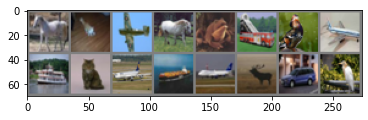

horse   cat plane horse


In [57]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [58]:
import torch.optim as optim

resnet = ResNet(output_classes=10, numBlocks=[2,2,2,2])
#gpu
resnet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [59]:
print(resnet)

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rblocks): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (trans): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (trans): Conv2d(64, 64, kernel_size=(1, 1), s

In [60]:
torch.cuda.is_available()

True

In [61]:
for epoch in range(1):  # loop over the dataset multiple times
    batch_count = 0
    #5-fold validation
    #let the k-th trainloader be the validation
    for k in range(5):
      for n_fold in range(5):
        _trainloader = training_loaders[n_fold]

        #do not train the validation data
        if(n_fold == k): continue

        running_loss = 0.0
        for _, data in enumerate(_trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #gpu
            inputs = inputs.cuda()
            labels = labels.cuda()
            #print(i, end = " ")

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_count +=1

            # print statistics
            running_loss += loss.item()
            if batch_count % 500 == 499:    # print every 500 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, batch_count + 1, running_loss / 500))
                running_loss = 0.0
        
                #validation
                validation_loader = training_loaders[k]

                correct = 0
                total = 0
                with torch.no_grad():
                    for data in validation_loader:
                        images, labels = data
                        #gpu
                        images = images.cuda()
                        labels = labels.cuda()
                        outputs = resnet(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the validation set: %d %%' % (
                    100 * correct / total))



print('Finished Training')

[1,   500] loss: 2.261
Accuracy of the network on the validation set: 17 %
[1,  1000] loss: 2.245
Accuracy of the network on the validation set: 20 %
[1,  1500] loss: 2.229
Accuracy of the network on the validation set: 23 %
[1,  2000] loss: 2.220
Accuracy of the network on the validation set: 24 %
[1,  2500] loss: 2.190
Accuracy of the network on the validation set: 23 %
[1,  3000] loss: 2.208
Accuracy of the network on the validation set: 26 %
[1,  3500] loss: 2.192
Accuracy of the network on the validation set: 28 %
[1,  4000] loss: 2.170
Accuracy of the network on the validation set: 28 %
[1,  4500] loss: 2.188
Accuracy of the network on the validation set: 28 %
[1,  5000] loss: 2.154
Accuracy of the network on the validation set: 27 %
[1,  5500] loss: 2.164
Accuracy of the network on the validation set: 25 %
[1,  6000] loss: 2.151
Accuracy of the network on the validation set: 29 %
[1,  6500] loss: 2.169
Accuracy of the network on the validation set: 28 %
[1,  7000] loss: 2.136
Ac

In [62]:
#test accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #gpu
        images = images.cuda()
        labels = labels.cuda()
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


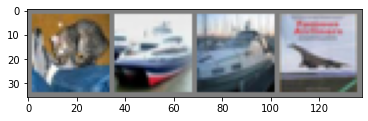

In [63]:
it = iter(testloader)
img, label = it.next()
imshow(torchvision.utils.make_grid(img))

In [64]:
img = img.cuda()
out = resnet(img)

In [65]:
out[0]

tensor([1.1714e-03, 6.7494e-05, 6.3858e-02, 8.4967e-01, 5.5794e-03, 3.0995e-04,
        7.9286e-02, 1.9486e-06, 8.4512e-06, 5.0403e-05], device='cuda:0',
       grad_fn=<SelectBackward>)

In [66]:
def predict(batch_img, class_num, show_top_n):
    imshow(torchvision.utils.make_grid(batch_img.cpu()))
    out = resnet(batch_img)
    cnt = 0
    for i in out:
        print("Image " + str(cnt))
        cnt += 1
        labelAcc = []
        for j in range(class_num):
            labelAcc.append([j,i[j]])
        labelAcc.sort(key = lambda s:s[1], reverse = True)
        for j in range(show_top_n):
            print(classes[labelAcc[j][0]] + ": " + str(float(labelAcc[j][1])))

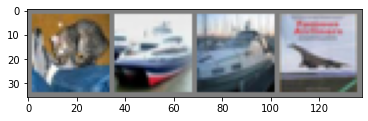

Image 0
cat: 0.8496667146682739
frog: 0.07928629219532013
Image 1
plane: 0.949557363986969
car: 0.05043414235115051
Image 2
car: 1.0
ship: 4.699398648000397e-10
Image 3
plane: 0.9995096921920776
ship: 0.0004902101936750114


In [67]:
predict(img, 10 ,2)

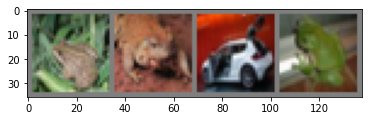

Image 0
cat: 0.4744272530078888
ship: 0.400687575340271
Image 1
frog: 1.0
cat: 7.377896515947668e-09
Image 2
car: 0.7227272391319275
dog: 0.14292758703231812
Image 3
frog: 0.33472272753715515
plane: 0.32305851578712463


In [68]:
img, label = it.next()
img = img.cuda()
out = resnet(img)
predict(img, 10, 2)

In [69]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [71]:
!ls "/content/gdrive/My Drive"

android_orientation_part2.gdoc	iir_training_python
android_orientation_part2.pdf


In [78]:
path = F"/content/gdrive/My Drive/iir_training_python/resnet18.pt"

In [79]:
#save model
torch.save(resnet.state_dict(), path)

In [ ]:
nn.Conv2d()

In [127]:
class ResidualBlockBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlockBottleneck,self).__init__()

        mid_channels = out_channels//4
        #convolution layer
        self.conv = nn.Sequential(nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride),
                     nn.Conv2d(mid_channels, mid_channels, kernel_size, padding=1),
                     nn.Conv2d(mid_channels, out_channels, kernel_size=1))
        
        #batch norm layer
        self.bn1 = nn.BatchNorm2d(num_features=mid_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        #transit the input x's shape to match the output f_x's shape
        self.trans = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
        #if input shape = output shape, no need to transut
        self.isChanged = not in_channels == out_channels
        
    def forward(self, x):
        f_x = self.conv[0](x)
        f_x = self.bn1(f_x)
        f_x = self.relu(f_x)
        f_x = self.conv[1](f_x)
        f_x = self.bn1(f_x)
        f_x = self.relu(f_x)
        f_x = self.conv[2](f_x)
        f_x = self.bn2(f_x)
        f_x = self.relu(f_x)
        
        #residual path
        if(self.isChanged):
            x = self.trans(x)
        #residual add
        x = f_x + x
        
        x = self.relu(x)
        
        return x
            

In [132]:
class ResNetDeep(nn.Module):
    def __init__(self, output_classes, numBlocks):
        super(ResNetDeep,self).__init__()
        
        self.sumOfRBlocks = sum(numBlocks)
        
        #convolution layer
        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2)
        self.bn = nn.BatchNorm2d(num_features=64)

        #residual blocks
        self.rblocks = nn.ModuleList()
        self.rblocks.append(ResidualBlockBottleneck(64,256))
        for i in range(numBlocks[0] - 1):
            self.rblocks.append(ResidualBlockBottleneck(256,256))
        
        self.rblocks.append(ResidualBlockBottleneck(256,512,stride=2))  
        for i in range(numBlocks[1] - 1):   
            self.rblocks.append(ResidualBlockBottleneck(512,512))
        
        self.rblocks.append(ResidualBlockBottleneck(512,1024,stride=2))
        for i in range(numBlocks[2] - 1):
            self.rblocks.append(ResidualBlockBottleneck(1024,1024))
        
        self.rblocks.append(ResidualBlockBottleneck(1024,2048,stride=2))
        for i in range(numBlocks[3] - 1):
            self.rblocks.append(ResidualBlockBottleneck(2048,2048))

        self.rblocks = nn.Sequential(*self.rblocks)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(2048, output_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.maxpool(x)
        
        for i in range(self.sumOfRBlocks):
          x = self.rblocks[i](x)
        
        x = self.avgpool(x)
        #reshape
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

In [144]:
resnetdeep = ResNetDeep(10,[3,4,6,3]).cuda()
summary(resnetdeep, (3,32,32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,160
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]          16,640
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]          16,640
             ReLU-14            [-1, 25

In [136]:
#split train data into 80% train 20% validation
len_trainset_5 = (int)(len(trainset)/5)
training_set, valid_set = torch.utils.data.random_split(trainset, [len_trainset_5*4,len_trainset_5])

training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True, num_workers=4)

In [139]:
print(len(valid_loader))
len(training_loader)

313


1250

In [141]:
import torch.optim as optim

resnetdeep = ResNetDeep(output_classes=10, numBlocks=[3,4,6,3])
#gpu
resnetdeep.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnetdeep.parameters(), lr=0.001, momentum=0.9)

In [142]:
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #gpu
        inputs = inputs.cuda()
        labels = labels.cuda()
        #print(i, end = " ")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnetdeep(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    
            #validation
            correct = 0
            total = 0
            with torch.no_grad():
                for data in valid_loader:
                    images, labels = data
                    #gpu
                    images = images.cuda()
                    labels = labels.cuda()
                    outputs = resnetdeep(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the validation set: %d %%' % (
                100 * correct / total))



print('Finished Training')

[1,  1000] loss: 2.180
Accuracy of the network on the validation set: 33 %
[2,  1000] loss: 2.083
Accuracy of the network on the validation set: 39 %
[3,  1000] loss: 2.051
Accuracy of the network on the validation set: 40 %
[4,  1000] loss: 2.015
Accuracy of the network on the validation set: 46 %
[5,  1000] loss: 1.977
Accuracy of the network on the validation set: 47 %
[6,  1000] loss: 1.959
Accuracy of the network on the validation set: 50 %
[7,  1000] loss: 1.942
Accuracy of the network on the validation set: 50 %
[8,  1000] loss: 1.930
Accuracy of the network on the validation set: 52 %
[9,  1000] loss: 1.920
Accuracy of the network on the validation set: 52 %
[10,  1000] loss: 1.909
Accuracy of the network on the validation set: 53 %
[11,  1000] loss: 1.897
Accuracy of the network on the validation set: 53 %
[12,  1000] loss: 1.886
Accuracy of the network on the validation set: 53 %
[13,  1000] loss: 1.876
Accuracy of the network on the validation set: 55 %
[14,  1000] loss: 1.8

In [143]:
#test accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #gpu
        images = images.cuda()
        labels = labels.cuda()
        outputs = resnetdeep(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [149]:
it = iter(testloader)

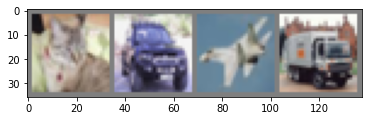

Image 0
dog: 0.5855405330657959
deer: 0.3394276201725006
Image 1
car: 0.9999997615814209
truck: 2.1719165488320868e-07
Image 2
plane: 0.9999996423721313
ship: 3.49733340954117e-07
Image 3
truck: 0.9999971389770508
horse: 2.8546276098495582e-06


In [152]:
img, label = it.next()
img = img.cuda()
out = resnet(img)
predict(img, 10, 2)

In [153]:
path = F"/content/gdrive/My Drive/iir_training_python/resnet50.pt"

In [154]:
torch.save(resnetdeep.state_dict, path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNetDeep. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResidualBlockBottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Resnet 101

In [155]:
resnetdeep = ResNetDeep(10,[3,4,23,3]).cuda()
summary(resnetdeep, (3,32,32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,160
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]          16,640
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]          16,640
             ReLU-14            [-1, 25

In [157]:
import torch.optim as optim

resnet101 = ResNetDeep(output_classes=10, numBlocks=[3,4,23,3])
#gpu
resnet101.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet101.parameters(), lr=0.001, momentum=0.9)

In [158]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #gpu
        inputs = inputs.cuda()
        labels = labels.cuda()
        #print(i, end = " ")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    
            #validation
            correct = 0
            total = 0
            with torch.no_grad():
                for data in valid_loader:
                    images, labels = data
                    #gpu
                    images = images.cuda()
                    labels = labels.cuda()
                    outputs = resnet101(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the validation set: %d %%' % (
                100 * correct / total))



print('Finished Training')

[1,  1000] loss: 2.269
Accuracy of the network on the validation set: 20 %
[2,  1000] loss: 2.195
Accuracy of the network on the validation set: 27 %
[3,  1000] loss: 2.130
Accuracy of the network on the validation set: 34 %
[4,  1000] loss: 2.069
Accuracy of the network on the validation set: 39 %
[5,  1000] loss: 2.043
Accuracy of the network on the validation set: 41 %
[6,  1000] loss: 2.027
Accuracy of the network on the validation set: 43 %
[7,  1000] loss: 2.018
Accuracy of the network on the validation set: 43 %
[8,  1000] loss: 2.012
Accuracy of the network on the validation set: 45 %
[9,  1000] loss: 1.994
Accuracy of the network on the validation set: 45 %
[10,  1000] loss: 1.991
Accuracy of the network on the validation set: 45 %
[11,  1000] loss: 1.987
Accuracy of the network on the validation set: 47 %
[12,  1000] loss: 1.974
Accuracy of the network on the validation set: 48 %
[13,  1000] loss: 1.969
Accuracy of the network on the validation set: 48 %
[14,  1000] loss: 1.9

In [159]:
path = F"/content/gdrive/My Drive/iir_training_python/resnet101.pt"

In [160]:
torch.save(resnet101.state_dict, path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNetDeep. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResidualBlockBottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
